In [1]:
# %matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/dart/'
# save_path         = '~/tripyview/Results/test_streaml/' #None
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
vname_vec = 'vec+u+v'
do_cgrain = False # do coarse graining (True) or linear interpolation (False) of u,v data to regular grid
year      = [1958, 1958]
mon       = None
day       = None
record    = None 
box       = None
depth     = 250

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 150 #300
save_fmt          = ['png']

In [3]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    
#     # disable dask worker heartbeat --> prevent error ?
#     from dask import config as cfg
#     cfg.set({'distributed.scheduler.worker-ttl': None})
    
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=False, do_joblib=False)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)  

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None):
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > load mesh from *.out files: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load e_area from fesom.mesh.diag.nc
 > load n_area from fesom.mesh.diag.nc
 > compute lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/tripyview_fesom2_core2_srt_dep@node_pbnd.shp
 > augment lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/tripyview_fesom2_core2_srt_dep@node_focus=0.shp
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


## --> Build matplotlib triangulation

<IPython.core.display.Javascript object>


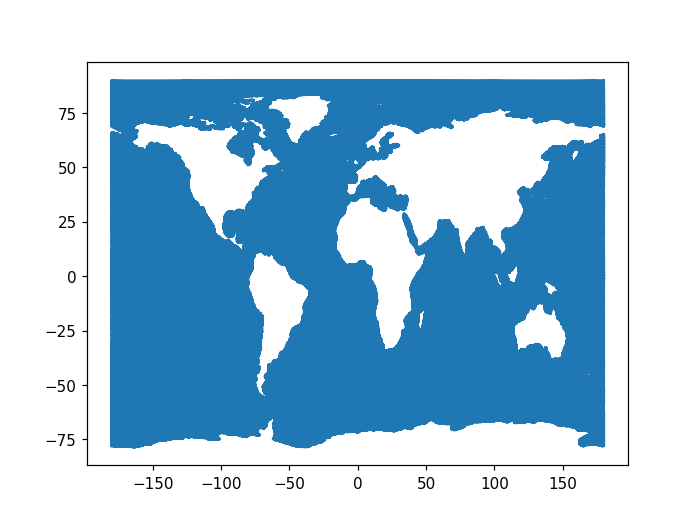

In [5]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
xa       = np.hstack((mesh.n_x,mesh.n_xa))
ya       = np.hstack((mesh.n_y,mesh.n_ya))
e_ia     = np.vstack((mesh.e_i[mesh.e_pbnd_0,:],mesh.e_ia))
# e_ia     = np.vstack((mesh.e_i[mesh.e_pbnd_0,:]))
tri_a    = mtri.Triangulation(xa, ya, e_ia)

plt.figure()
plt.triplot(tri_a)
plt.show()

## --> Check for, duplicated points, collinear triangles, overlapping triangles

In [6]:
points  = np.column_stack((tri_a.x, tri_a.y))

#___________________________________________________________________________________________
# Check for duplicated points
unique_points, counts = np.unique(points, axis=0, return_counts=True)
duplicates = unique_points[counts > 1]
if len(duplicates) > 0:
    print(f"Duplicate points found: {duplicates}")
else:
    print("No duplicate points.")



#___________________________________________________________________________________________    
# Check for colinear triangles (very flat triangles, all triangles points are positioned in a 
# line)    
# Calculate area of each triangle
def is_collinear(p1, p2, p3):
    # Area formula: (1/2) * |x1(y2 - y3) + x2(y3 - y1) + x3(y1 - y2)|
    area = 0.5 * abs(p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1]))
    return area == 0

collinear_triangles = []
for i, tri in enumerate(tri_a.triangles):
    p1, p2, p3 = points[tri[0]], points[tri[1]], points[tri[2]]
    if is_collinear(p1, p2, p3):
        collinear_triangles.append(i)

if collinear_triangles:
    print(f"Collinear triangles found at indices: {collinear_triangles}")
else:
    print("No collinear triangles.")
    

    

#___________________________________________________________________________________________
# Check for triangles that overlapp each other such as periodic boundary triangles 
from shapely.geometry import Polygon
from rtree import index
import numpy as np

# Assuming `points` is an array of (x, y) coordinates and `triangulation` is defined
# Create an array of Shapely polygons from triangles
print(' --> build polygon list')
triangles = []
for tri in tri_a.triangles:
    p1, p2, p3 = points[tri[0]], points[tri[1]], points[tri[2]]
    triangles.append(Polygon([p1, p2, p3]))

# Initialize the R-tree index
print(' --> initialize rtree index')
idx = index.Index()
for i, triangle in enumerate(triangles):
    if np.mod(i,100000)==0: print(i,mesh.n2dea)
    idx.insert(i, triangle.bounds)  # Insert bounding box of each triangle

# Check for overlapping triangles using the spatial index
print(' --> check 4 overlapping')
overlapping_pairs = set()  # Use a set to avoid duplicate pairs
for i, poly1 in enumerate(triangles):
    if np.mod(i,100000)==0: print(i,mesh.n2dea)
    # Query the index for possible overlaps with triangle `i`
    possible_matches = list(idx.intersection(poly1.bounds))

    for j in possible_matches:
        if i >= j:  # Avoid redundant checks and self-comparison
            continue
        poly2 = triangles[j]
        
        # Check for actual intersection without just touching
        if poly1.intersects(poly2) and not poly1.touches(poly2):
            overlapping_pairs.add((i, j))
            print((i, j))

if overlapping_pairs:
    print(f"Overlapping triangles found between indices: {list(overlapping_pairs)}")
else:
    print("No overlapping triangles.")

No duplicate points.
No collinear triangles.
 --> build polygon list
 --> initialize rtree index
0 245416
100000 245416
200000 245416
 --> check 4 overlapping
0 245416
100000 245416
200000 245416
No overlapping triangles.


<IPython.core.display.Javascript object>


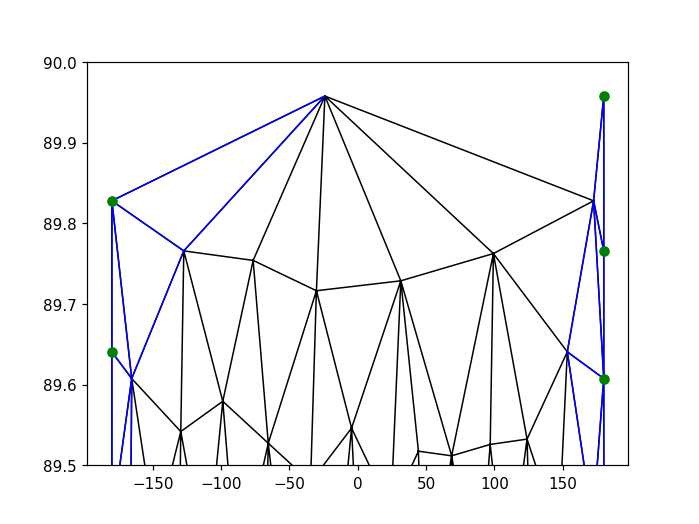

 --> n2de = 244659
 --> n2dea= 245416


(89.5, 90.0)

In [7]:
plt.figure()

# flat_overlappinglist = [item for sublist in overlapping_pairs for item in sublist]

print(' --> n2de =', mesh.n2de)
print(' --> n2dea=', mesh.n2dea)

# plt.triplot(mesh.n_x, mesh.n_y, mesh.e_i[:            ,:], color='k', linewidth=0.2)


plt.triplot(tri_a, color='k', linewidth=1.0)
# plt.triplot(mesh.n_x, mesh.n_y, mesh.e_i[mesh.e_pbnd_0,:], color='k', linewidth=1.0)
# plt.triplot(mesh.n_x, mesh.n_y, mesh.e_i[mesh.e_pbnd_1,:], color='r', linewidth=1.0)
plt.triplot(tri_a.x, tri_a.y, tri_a.triangles[mesh.e_pbnd_0.size:mesh.n2dea,:], color='b', linewidth=1.0)


# for ii in range(mesh.n2de,mesh.n2dea):

# #     if ii in [245416] :
#     if ii in flat_overlappinglist :
#         x, y = triangles[ii].exterior.xy
#         plt.plot(x, y, 'r-', linewidth=1.0)
#     else:    
        
#         x, y = triangles[ii].exterior.xy
#         plt.plot(x, y, 'b-', linewidth=0.5)  # 'b-' for a blue line
        
plt.plot(mesh.n_xa, mesh.n_ya,'o', color='green')    

plt.ylim(89.5,90.00)

## --> Check If mtri.LinearTriInterpolator(...) works

In [13]:
#______________________________________________________________________________________________________________
# do regular binning of diapycnal velocities
Rearth     = 6371e3
dlon, dlat = 1.0, 1.0
lon_reg    = np.arange(box[0], box[1]+dlon, dlon)
lat_reg    = np.arange(box[2], box[3]+dlat, dlat)
mlon_reg, mlat_reg = (lon_reg[1:]+lon_reg[:-1])/2.0, (lat_reg[1:]+lat_reg[:-1])/2.0

#______________________________________________________________________________________________________________
data_list, data_v_list = list(), list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    #__________________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    
    #__________________________________________________________________________________________________________
    # load vector data e.g. velocity
    ts = clock.time()
    data_v = tpv.load_data_fesom2(mesh, datapath, vname=vname_vec, year=yeari, mon=moni, day=dayi, record=recordi, 
                                  depth=depth, descript=descript, do_info=False, do_parallel=do_parallel, do_ie2n=True)
    
    # check if data where loaded
    if data_v is None: raise ValueError(f'data_vec == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data_v.nbytes/(1024**3)))
    print('')    
    

# Creat triangular linear interpolator 
vnm = list(data_v.data_vars)

da   = np.hstack((data_v[vnm[0]].data,data_v[vnm[0]].data[mesh.n_pbnd_a]))

# Create a regular grid to interpolate onto
xi, yi       = np.meshgrid(lon_reg, lat_reg)    

t1 = clock.time()
interp_u = mtri.LinearTriInterpolator(tri_a, da )
da_reg   = interp_u(xi, yi)
print(da_reg)
print(' --> elapsed time:', clock.time()-t1)

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 > do elem vector rotation
 > do interpolation e2n
 --> elasped time to load data: 0.05 min.
 --> data uses 0.00 Gb:

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [0.00041428419689126805 0.0008189502052751152 0.0010260092649426733 ...
  0.0007801853926994173 0.0010614641962671811 0.0011849347915925401]
 [0.00035610621295002753 0.0006408791503302175 0.0009256520877103935 ...
  0.0007073816452017323 0.0015206135596960157 0.0036090844355303187]
 [-- -- -- ... -- -- --]]
 --> elapsed time: 0.0725104808807373
